In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.layers import Attention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from IPython.display import HTML as html_print
from IPython.display import display
import keras.backend as K
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.metrics import multilabel_confusion_matrix, f1_score, precision_score, recall_score
import re
import os
import time
import numpy as np
import time
import string
import math
import matplotlib
import pickle

In [2]:
from pandas import DataFrame as df
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
lr = 0.0001
lr_decay = 1e-6
mom = 0.9
num_epochs = 600
batch_size = 10

Builds LSTM model based on embeddings of train scripts

In [0]:
def make_dataframe(text_file):
    id_lines = {}
    text_file = open(text_file, "r", encoding="ISO-8859-1")
    for line in text_file:
        fields = line.split(" +++$+++ ")
        if fields[2] not in id_lines:
            id_lines[fields[2]] = ''
        id_lines[fields[2]] = id_lines[fields[2]] + fields[4]
    # print(len(list(id_lines.values())))
    data = {'id': list(id_lines.keys()), 'scripts': list(id_lines.values())}
    # text_df = df(data = [list(id_lines.keys()), id_lines.values()])
    text_df = df(data)
    return text_df

In [6]:
practice_script = files.upload()

Saving train_scripts.txt to train_scripts.txt


In [7]:
premade_train_labels = files.upload()

Saving train_labels_continuous.npy to train_labels_continuous.npy


In [33]:
y = np.load("train_labels_continuous.npy")
text_df = make_dataframe("train_scripts.txt")
# print(text_df.info)
text_df.info()
text_df = text_df.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       432 non-null    object
 1   scripts  432 non-null    object
dtypes: object(2)
memory usage: 6.9+ KB


In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
text_df['scripts'] = text_df['scripts'].apply(clean_text)
text_df['scripts'] = text_df['scripts'].str.replace('\d+', '')

In [0]:
max_words = 50000
max_seq_len = 1000
embedding_dim = 100

In [36]:
tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(text_df['scripts'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 162043 unique tokens


In [37]:
X = tokenizer.texts_to_sequences(text_df['scripts'].values)
X = pad_sequences(X, maxlen = max_seq_len)
print(X.shape)

(432, 1000)


In [0]:
print(y.shape)

(432, 24)


In [0]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(24, activation='sigmoid'))

# sgd = SGD(lr = lr, decay = lr_decay, momentum = mom)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
num_epochs = 50
batch_size = 36

In [40]:
start = time.time()
history = model.fit(X, y, epochs = num_epochs, batch_size = batch_size)
print("Training Time:", time.time() - start)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
432/432 [==============================] - 14s 33ms/step - loss: 9.4751 - accuracy: 0.1273
Epoch 2/50
432/432 [==============================] - 14s 31ms/step - loss: 8.5133 - accuracy: 0.1134
Epoch 3/50
432/432 [==============================] - 14s 31ms/step - loss: 8.0165 - accuracy: 0.1134
Epoch 4/50
432/432 [==============================] - 14s 31ms/step - loss: 7.9121 - accuracy: 0.1227
Epoch 5/50
432/432 [==============================] - 14s 31ms/step - loss: 7.8876 - accuracy: 0.1412
Epoch 6/50
432/432 [==============================] - 14s 32ms/step - loss: 7.8370 - accuracy: 0.1505
Epoch 7/50
432/432 [==============================] - 14s 32ms/step - loss: 7.8690 - accuracy: 0.1481
Epoch 8/50
432/432 [==============================] - 14s 32ms/step - loss: 7.8213 - accuracy: 0.1829
Epoch 9/50
432/432 [==============================] - 14s 32ms/step - loss: 7.8241 - accuracy: 0.1875
Epoch 10/50
432/432 [==============================] - 14s 32ms/step - loss: 7.797

In [0]:
file_path = F"/content/gdrive/My Drive/model_50_lstm_bs_36.h5" 

In [0]:
model.save(file_path)

In [43]:
file_path = F"/content/gdrive/My Drive/model_50_lstm_bs_36.h5" 
from keras.models import load_model
loaded_model = load_model(file_path)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [17]:
genre_idx = files.upload()
with open("genre_idx.pickle", "rb") as f:
  genre_idx = pickle.load(f)

Saving genre_idx.pickle to genre_idx.pickle


In [44]:
load_preds = loaded_model.predict(X)
genres = list(genre_idx.keys())
num = 19

load_preds[load_preds >= 0.50] = 1
load_preds[load_preds < 0.50] = 0
print("Predict:", load_preds[num])
print("Answers:", y[num])

score = np.subtract(y[num], load_preds[num])
score = np.linalg.norm(score)
print("Score:", score)

sum_score = 0
num_wrong = 0
for i in range(len(load_preds)):
  score = np.subtract(y[i], load_preds[i])
  score = np.linalg.norm(score)
  if score != 0:
    num_wrong += 1
  sum_score += score
total_score = sum_score / len(load_preds)
print("Avg Score:", total_score)
print("Wrong:", num_wrong)

Predict: [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
Answers: [1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
Score: 1.0
Avg Score: 0.5012259032271361
Wrong: 161


In [0]:
print(num_wrong / len(preds))

0.009259259259259259


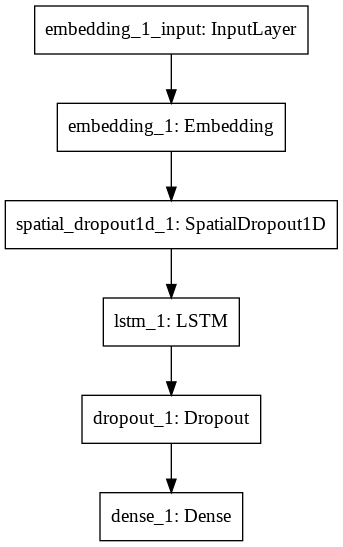

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [119]:
word_embeddings = loaded_model.layers[0].get_weights()
word_embeddings = np.array(word_embeddings[0])
print(word_embeddings[0])

[-0.0497767  -0.00381653  0.00130438  0.06811976  0.03343548 -0.01465595
 -0.00829697 -0.04895847  0.00841788 -0.00286682 -0.02988979  0.07724951
 -0.00560961  0.02555392  0.01595614 -0.05894598 -0.05076253  0.01157817
 -0.05027363  0.00096349  0.04794193  0.035544   -0.0637528  -0.01775996
 -0.01636992 -0.05126927  0.00279301 -0.03051776  0.00593016 -0.01882827
  0.01141939 -0.00966304 -0.02526717  0.00422843  0.00966795 -0.01029817
  0.05594499  0.02355724 -0.05084321 -0.00941433 -0.07162    -0.0287885
 -0.03234075 -0.01939624 -0.02362772  0.03115773  0.04437302  0.07681634
 -0.00152104  0.06608161  0.03654118  0.03316184  0.05271103  0.04774142
  0.00050863  0.05022999  0.03397113  0.04452194 -0.02541644  0.00200214
  0.01666598 -0.03571161  0.02447609 -0.02186639  0.03804906  0.0229846
 -0.01716697 -0.0058475  -0.0368012   0.06086661 -0.03700871 -0.05110006
  0.00401584  0.03178221  0.00891861 -0.03908984  0.05054741 -0.04447621
 -0.0157892   0.02738454  0.03049232 -0.01209684  0.0

In [120]:
lstm_weights = loaded_model.layers[2].get_weights()
lstm_weights = np.array(lstm_weights[0])
print(lstm_weights[0])

[ 9.02187228e-02 -3.11767985e-03 -2.73932014e-02  1.66215017e-01
 -2.74504088e-02  2.36948282e-02  1.21354640e-01  5.07580750e-02
 -4.66752574e-02  2.32931137e-01  1.83917210e-01 -8.41957927e-02
  7.88232982e-02 -3.51570696e-02  1.37710720e-01 -1.10817194e-01
  6.85872138e-02  1.04311660e-01 -2.73951832e-02  8.20243806e-02
  5.58649376e-02 -1.73063084e-01 -7.78674856e-02  3.64394709e-02
  2.38611490e-01  8.65330100e-02 -1.37446806e-01  4.09387439e-01
 -1.48589797e-02  1.60416961e-02  3.87024619e-02 -5.00844419e-02
 -3.76537383e-01  3.99096124e-03 -9.98565033e-02 -3.70832309e-02
  1.50836557e-01  5.27546778e-02 -1.16328001e-01  1.00492230e-02
 -5.14498800e-02 -1.99158657e-02  4.25773300e-02  1.59547199e-03
 -7.44999945e-02  1.10444844e-01 -1.63104042e-01 -1.43782407e-01
 -3.65198776e-02 -4.58029062e-02 -6.48027137e-02  4.29834165e-02
 -4.14979495e-02  2.82811783e-02 -1.28211170e-01 -1.58188343e-01
  1.29642829e-01  1.39681771e-01  2.07854584e-02 -1.84675291e-01
 -1.65890470e-01  5.44132

In [121]:
dense = loaded_model.layers[4].get_weights()
dense = np.array(dense[0])
print(dense[0])

[ 0.1536246  -0.17608829  0.38737148  0.13504224 -0.11659513 -0.09205896
  0.13647415 -0.12433041 -0.23964295  0.00163074  0.1254083   0.3418682
 -0.11856705 -0.2322168  -0.00941646 -0.1050911   0.45919994  0.16866463
  0.04100294  0.15853547  0.38071004 -0.02444674  0.02604264 -0.07803123]


In [0]:
word_list = []
for word, i in tokenizer.word_index.items():
    word_list.append(word)
print(word_list[0])
print(word_index['dont'])
print(len(word_list))
print(len(word_index.keys()))

dont
1
161993
161993


In [0]:
out_v = open('vecs.tsv', 'w', encoding='utf-8')
out_m = open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(word_list):
  vec = word_embeddings[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [0]:
lstm_layer = model.layers[2]
attn_func = K.function(inputs = [model.get_input_at(0)],
           outputs = [lstm_layer.output]
          )

In [0]:
# get html element
def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
# print html
def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
	colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
	value = int((value * 100) / 5)
	return colors[value]

# sigmoid function
def sigmoid(x):
	z = 1/(1 + np.exp(-x)) 
	return z

In [0]:
def visualize(output_values, result_list, cell_no):
	print("\nCell Number:", cell_no, "\n")
	text_colours = []
	for i in range(len(output_values)):
		text = (result_list[i], get_clr(output_values[i][cell_no]))
		text_colours.append(text)
	print_color(text_colours)

In [0]:
def get_predictions(data):
    print(len(data))
    start = np.random.randint(0, len(data) - 1)
    pattern = data[start]
    result_list, output_values = [], []
    print("Seed:")
    print("\"" + ''.join([int_to_char[value] for value in pattern]) + "\"")
    print("\nGenerated:")

    for i in range(1000):
        # Reshaping input array for predicting next character
        x = np.reshape(pattern, (1, len(pattern)))
        x = x / float(n_vocab)
        # print(x.shape)

        # Prediction
        prediction = model.predict(x, verbose=0)

        # LSTM Activations
        output = attn_func([x])[0][0]
        output = sigmoid(output)
        output_values.append(output)

        # Predicted Character
        index = np.argmax(prediction)
        result = int_to_char[index]

        # Preparing input for next character
        seq_in = [int_to_char[value] for value in pattern]
        # print(len(seq_in))
        np.append(pattern, index)
        pattern = pattern[0:len(pattern)]

        # Saving generated characters
        result_list.append(result)
    return output_values, result_list

In [0]:
def get_word_predictions(data):
  result_list, output_list = [], []
  for start in range(0, len(data), 100):
    pattern = data[start]
    print("Seed:")
    print("\"" + ''.join([int_to_char[value] for value in pattern]) + "\"")
    print("\nGenerated:")

    x = np.reshape(pattern, (1, len(pattern)))
    x = x / float(n_vocab)

    # Prediction
    prediction = model.predict(x, verbose=0)

    # LSTM Activations
    output = attn_func([x])[0][0]
    output = sigmoid(output)
    output_values.append(output)

    # Predicted Character
    index = np.argmax(prediction)
    result = int_to_char[index]

    result_list.append(result)
  return output_values, result_list

In [0]:
int_to_char = {}
for key in word_index.keys():
  int_to_char[word_index[key] - 1] = key
n_vocab = len(list(word_index.keys()))

In [100]:
output_values, result_list = get_word_predictions(X)
print(output_values)
# for cell_no in [189, 435, 463]:
# 	visualize(output_values, result_list, cell_no)

Streaming output truncated to the last 5000 lines.
       0.6905937 , 0.29240555, 0.38595518, 0.37370598, 0.7093039 ,
       0.6564346 , 0.6285147 , 0.6862169 , 0.6812752 , 0.6497171 ,
       0.29652858, 0.30170977, 0.28870514, 0.69874126, 0.55178356,
       0.5776473 , 0.2969134 , 0.6462114 , 0.6676526 , 0.302848  ,
       0.293512  , 0.3269841 , 0.71554345, 0.30036303, 0.30631438,
       0.5668656 , 0.30021128, 0.56623465, 0.48311973, 0.3321969 ,
       0.38158646, 0.70546675, 0.655009  , 0.64366966, 0.6824887 ,
       0.5159558 , 0.3257103 , 0.64704645, 0.6483379 , 0.5796165 ,
       0.28109366, 0.5548677 , 0.6422162 , 0.7228717 , 0.6305434 ,
       0.52192956, 0.38077798, 0.6618084 , 0.54478014, 0.572351  ,
       0.35488907, 0.4007569 , 0.65021527, 0.32875073, 0.6546486 ,
       0.6283647 , 0.6614821 , 0.28746408, 0.5912979 , 0.31454733,
       0.45286095, 0.36786255, 0.27343577, 0.32951492, 0.45494792,
       0.3441862 , 0.70356864, 0.6717305 , 0.6398346 , 0.6824909 ,
       0.38

In [106]:
print(result_list)
print(len(output_values[1]))
visualize(output_values, result_list, 3)

['got', 'got', 'got', 'got', 'got']
100

Cell Number: 3 



IndexError: ignored

In [0]:
preds = model.predict(X)
genres = list(genre_idx.keys())
n = 2

sorted_pred = [i for _,i in sorted(zip(preds[n], genres), reverse = True)]
print(sorted_pred)

preds[preds >= 0.50] = 1
preds[preds < 0.50] = 0
correct_gen = []
bin_pred = []
for i in range(len(y[0])):
  if preds[n][i] == 1:
    bin_pred.append(genres[i])
  if y[n][i] == 1:
    correct_gen.append(genres[i])
print("Prediction:", bin_pred)
print("Answer:", correct_gen)

# preds[preds >= 0.50] = 1
# preds[preds < 0.50] = 0
print(preds[n])
print(y[n])
print(np.subtract(y[n], preds[n]))

['romance', 'western', 'war', 'thriller', 'mystery', 'biography', 'filmnoir', 'action', 'musical', 'sport', 'short', 'fantasy', 'comedy', 'drama', 'horror', 'adult', 'history', 'scifi', 'documentary', 'music', 'family', 'adventure', 'crime', 'animation']
Prediction: ['action', 'biography', 'comedy', 'fantasy', 'filmnoir', 'musical', 'mystery', 'romance', 'short', 'sport', 'thriller', 'war', 'western']
Answer: ['action', 'comedy', 'crime', 'drama', 'thriller']
[1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
[1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[ 0.  0.  0.  0. -1.  0.  1.  0.  1.  0. -1. -1.  0.  0.  0. -1. -1. -1.
  0. -1. -1.  0. -1. -1.]


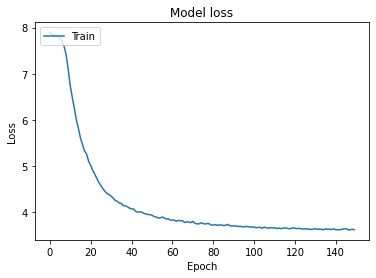

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

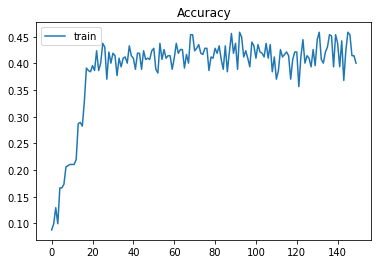

In [0]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.legend()
plt.show()

In [0]:
for i, p in enumerate(preds[0]):
  print(i, p)

NameError: ignored

In [0]:
print(sorted(preds[0], reverse=True))

[0.99463165, 0.985374, 0.5450674, 0.52131265, 0.50324166, 0.44590178, 0.37567335, 0.3290327, 0.3281529, 0.2997863, 0.26876092, 0.08530855, 0.08433205, 0.067121, 0.06462282, 0.04828462, 0.04785475, 0.03907919, 0.030789107, 0.028788447, 0.015551388, 0.0110602975, 0.010817409, 0.0057459474]


In [0]:
from IPython.display import HTML as html_print
from IPython.display import display
import keras.backend as K

In [20]:
test_script = files.upload()
test_labels = files.upload()

Saving test_scripts.txt to test_scripts.txt


Saving test_labels.npy to test_labels.npy


In [0]:
test_answers = np.load("test_labels.npy")
test_df = make_dataframe("test_scripts.txt")

test_df = test_df.reset_index(drop=True)
test_df['scripts'] = test_df['scripts'].apply(clean_text)
test_df['scripts'] = test_df['scripts'].str.replace('\d+', '')

In [22]:
test_tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
test_tokenizer.fit_on_texts(test_df['scripts'].values)
test_word_index = test_tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 162043 unique tokens


In [0]:
X_test = test_tokenizer.texts_to_sequences(test_df['scripts'].values)
X_test = pad_sequences(X_test, maxlen = max_seq_len)

In [0]:
print(X_test.shape)
print(test_answers.shape)

(185, 1000)
(185, 24)


In [0]:
test_guesses = loaded_model.predict(X_test)

genres = list(genre_idx.keys())
n = 12

sorted_guess = [i for _,i in sorted(zip(test_guesses[n], genres), reverse = True)]
print(sorted_guess)

test_guesses[test_guesses >= 0.30] = 1
test_guesses[test_guesses < 0.30] = 0
answer = []
bin_guess = []
for i in range(len(test_answers[0])):
  if test_guesses[n][i] == 1:
    bin_guess.append(genres[i])
  if test_answers[n][i] == 1:
    answer.append(genres[i])
print("Prediction:", bin_guess)
print("Answer:", answer)

['adventure', 'scifi', 'fantasy', 'action', 'family', 'comedy', 'war', 'documentary', 'mystery', 'horror', 'filmnoir', 'musical', 'romance', 'short', 'thriller', 'drama', 'sport', 'animation', 'music', 'adult', 'biography', 'history', 'western', 'crime']
Prediction: ['adventure', 'fantasy', 'scifi']
Answer: ['action', 'crime', 'drama', 'horror', 'scifi', 'thriller']


In [46]:
test_preds = loaded_model.predict(X_test)
genres = list(genre_idx.keys())
num = 19

test_preds[test_preds >= 0.50] = 1
test_preds[test_preds < 0.50] = 0
print("Predict:", test_preds[num])
print("Answers:", test_answers[num])

test_score = np.subtract(test_answers[num], test_preds[num])
test_score = np.linalg.norm(test_score)
print("Score:", test_score)

sum_test_score = 0
num_test_wrong = 0
for i in range(len(test_preds)):
  test_score = np.subtract(test_answers[i], test_preds[i])
  test_score = np.linalg.norm(test_score)
  if test_score != 0:
    num_test_wrong += 1
  sum_test_score += test_score
total_test_score = sum_test_score / len(test_preds)
print("Avg Score:", total_test_score)
print("Wrong:", num_test_wrong)

Predict: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
Answers: [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Score: 2.23606797749979
Avg Score: 1.661455316081062
Wrong: 181


In [45]:
## TRAIN F1 SCORES
f1_micro = f1_score(y, load_preds, average = 'micro')
f1_macro = f1_score(y, load_preds, average = 'macro', zero_division = 1)
print("Micro:", f1_micro)
print("Macro:", f1_macro)

Micro: 0.8629310344827585
Macro: 0.6666968284845515


In [49]:
## TEST F1 SCORES
f1_micro = f1_score(test_answers, test_preds, average = 'micro')
f1_macro = f1_score(test_answers, test_preds, average = 'macro', zero_division = 1)
print("Micro:", f1_micro)
print("Macro:", f1_macro)

Micro: 0.14106583072100315
Macro: 0.08490152049514481
